In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

# Описание датасета (взято с kaggle)

id	(continous)	Уникальный идентификатор Клиента.

Age	(continous)	Возраст клиента.

Gender	(dichotomous)	Пол клиента.

Driving_License	(dichotomous)	0 для клиента, у которого нет водительских прав, 1 для клиента, у которого есть водительские права.

Region_Code	(nominal)	Уникальный код для региона клиента.

Previously_Insured	(dichotomous)	0 для клиента, не имеющего страховки на транспортное средство, 1 для клиента, имеющего страховку на транспортное средство.

Vehicle_Age	(nominal)	Возраст транспортного средства.

Vehicle_Damage	(dichotomous)	1: В прошлом у клиента был поврежден автомобиль. 0: В прошлом у клиента не было повреждений автомобиля.

Annual_Premium	(continous)	Сумма, которую клиент должен заплатить в качестве взноса в течение года.

Policy_Sales_Channel	(nominal)	Анонимизированный код для канала связи с клиентом, т.е. Различные агенты, по почте, телефону, лично и т.д.

Vintage	(continous)	Количество дней, в течение которых Клиент был связан с компанией.

Response (Dependent Feature)	(dichotomous)	1 означает, что Клиент заинтересован, 0 - что Клиент не заинтересован.

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [3]:
df_test = pd.read_csv('test.csv')
df_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,5000000,Female,44,1,36.0,1,1-2 Year,No,2630.0,152.0,182,0
1,5000001,Male,61,1,28.0,0,> 2 Years,Yes,41372.0,30.0,77,1
2,5000002,Male,44,1,0.0,1,1-2 Year,No,2630.0,122.0,107,0
3,5000003,Male,25,1,28.0,0,< 1 Year,No,2630.0,152.0,248,0
4,5000004,Female,26,1,2.0,1,< 1 Year,No,38414.0,160.0,24,0


In [4]:
# sns.pairplot(df)

# Предобработка

In [5]:
df = df.drop('id', axis=1) # Удаление бесполезного признака id
df_test = df_test.drop('id', axis=1)
df.dtypes

Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [6]:
print('max train\n', df.max())
print('\nmin train\n', df.min())
print('\nmax test\n', df_test.max())
print('\nmin test\n', df_test.min())

max train
 Gender                       Male
Age                            85
Driving_License                 1
Region_Code                  52.0
Previously_Insured              1
Vehicle_Age             > 2 Years
Vehicle_Damage                Yes
Annual_Premium           540165.0
Policy_Sales_Channel        163.0
Vintage                       299
Response                        1
dtype: object

min train
 Gender                    Female
Age                           20
Driving_License                0
Region_Code                  0.0
Previously_Insured             0
Vehicle_Age             1-2 Year
Vehicle_Damage                No
Annual_Premium            2630.0
Policy_Sales_Channel         1.0
Vintage                       10
Response                       0
dtype: object

max test
 Gender                       Male
Age                            85
Driving_License                 1
Region_Code                  52.0
Previously_Insured              1
Vehicle_Age             > 2 Yea

In [7]:
df['Response'].value_counts()

Response
0    4384719
1     615281
Name: count, dtype: int64

Виден дисбаланс, но пока забьем

In [8]:
df.isna().sum().count

<bound method Series.count of Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64>

In [9]:
df_test.isna().sum().count

<bound method Series.count of Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64>

Пропусков нет

### Заменим значения признака Vehicle_Age на порядковые, а признаков Vehicle_Damage, Driving_license, Previously_Insured - на булевые значения

In [10]:
v_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}

df['Vehicle_Age'] = df['Vehicle_Age'].map(v_age_mapping)
df_test['Vehicle_Age'] = df_test['Vehicle_Age'].map(v_age_mapping)


v_damage_mapping = {'Yes': True, 'No': False}

df['Vehicle_Damage'] = df['Vehicle_Damage'].map(v_damage_mapping)
df_test['Vehicle_Damage'] = df_test['Vehicle_Damage'].map(v_damage_mapping)


bool_mapping = {1: True, 0: False}

df['Driving_License'] = df['Driving_License'].map(bool_mapping)
df['Previously_Insured'] = df['Previously_Insured'].map(bool_mapping)

df_test['Driving_License'] = df_test['Driving_License'].map(bool_mapping)
df_test['Previously_Insured'] = df_test['Previously_Insured'].map(bool_mapping)

df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,21,True,35.0,False,1,True,65101.0,124.0,187,0
1,Male,43,True,28.0,False,2,True,58911.0,26.0,288,1
2,Female,25,True,14.0,True,0,False,38043.0,152.0,254,0
3,Female,35,True,1.0,False,1,True,2630.0,156.0,76,0
4,Female,36,True,15.0,True,1,False,31951.0,152.0,294,0


### Преобразуем признаки Policy_Sales_Channel и Region_Code в категориальные, ибо они несут именно такой смысл

In [11]:
print(df['Policy_Sales_Channel'].unique().size)
print(df['Region_Code'].unique().size)

149
53


In [12]:
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('object')
df['Region_Code'] = df['Region_Code'].astype('object')

df_test['Policy_Sales_Channel'] = df_test['Policy_Sales_Channel'].astype('object')
df_test['Region_Code'] = df_test['Region_Code'].astype('object')

df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,21,True,35.0,False,1,True,65101.0,124.0,187,0
1,Male,43,True,28.0,False,2,True,58911.0,26.0,288,1
2,Female,25,True,14.0,True,0,False,38043.0,152.0,254,0
3,Female,35,True,1.0,False,1,True,2630.0,156.0,76,0
4,Female,36,True,15.0,True,1,False,31951.0,152.0,294,0


### Нормировка

In [13]:
numerical_features = df.select_dtypes(exclude=['object', 'bool']).columns
numerical_features = np.delete(numerical_features, np.where(numerical_features == 'Response'))

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])
df_test[numerical_features] = scaler.transform(df_test[numerical_features])

df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,-1.159421,True,35.0,False,0.698792,True,2.101969,124.0,0.288605,0
1,Male,0.307563,True,28.0,False,2.459899,True,1.726275,26.0,1.551506,1
2,Female,-0.892696,True,14.0,True,-1.062316,False,0.459721,152.0,1.126371,0
3,Female,-0.225886,True,1.0,False,0.698792,True,-1.689623,156.0,-1.099336,0
4,Female,-0.159205,True,15.0,True,0.698792,False,0.089975,152.0,1.626530,0


### Выполним One-hot кодирование

In [14]:
df_onehot = pd.get_dummies(df, drop_first=True)
df_test_onehot = pd.get_dummies(df_test, drop_first=True)

df_onehot.head()

,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response,Gender_Male,Region_Code_1.0,...,Policy_Sales_Channel_152.0,Policy_Sales_Channel_153.0,Policy_Sales_Channel_154.0,Policy_Sales_Channel_155.0,Policy_Sales_Channel_156.0,Policy_Sales_Channel_157.0,Policy_Sales_Channel_158.0,Policy_Sales_Channel_159.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_163.0
0,-1.159421,True,False,0.698792,True,2.101969,0.288605,0,True,False,...,False,False,False,False,False,False,False,False,False,False
1,0.307563,True,False,2.459899,True,1.726275,1.551506,1,True,False,...,False,False,False,False,False,False,False,False,False,False
2,-0.892696,True,True,-1.062316,False,0.459721,1.126371,0,False,False,...,True,False,False,False,False,False,False,False,False,False
3,-0.225886,True,False,0.698792,True,-1.689623,-1.099336,0,False,True,...,False,False,False,False,True,False,False,False,False,False
4,-0.159205,True,True,0.698792,False,0.089975,1.626530,0,False,False,...,True,False,False,False,False,False,False,False,False,False


<Axes: >

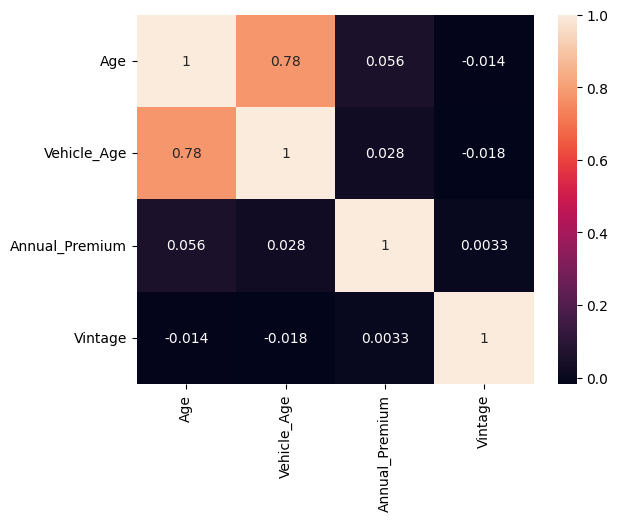

In [18]:
sns.heatmap(df[numerical_features].corr(), annot=True)

# Модели

In [19]:
X_train = df_onehot.drop('Response', axis=1)
y_train = df_onehot['Response']

X_test = df_test_onehot.drop('Response', axis=1)
y_test = df_test_onehot['Response']



### В тренировочной и тестовой выборках немного разнится набор столбцов. Выявим и удалим отличающиеся

In [20]:
train_to_delete = list(set(X_train) - set(X_test))
print(train_to_delete)
test_to_delete = list(set(X_test) - set(X_train))
print(test_to_delete)

['Policy_Sales_Channel_6.0']
['Policy_Sales_Channel_102.0', 'Policy_Sales_Channel_5.0', 'Policy_Sales_Channel_112.0', 'Region_Code_39.2']


In [21]:
X_train = X_train.drop(train_to_delete, axis=1)
X_test = X_test.drop(test_to_delete, axis=1)
X_train.head()

,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Gender_Male,Region_Code_1.0,Region_Code_2.0,...,Policy_Sales_Channel_152.0,Policy_Sales_Channel_153.0,Policy_Sales_Channel_154.0,Policy_Sales_Channel_155.0,Policy_Sales_Channel_156.0,Policy_Sales_Channel_157.0,Policy_Sales_Channel_158.0,Policy_Sales_Channel_159.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_163.0
0,-1.159421,True,False,0.698792,True,2.101969,0.288605,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.307563,True,False,2.459899,True,1.726275,1.551506,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-0.892696,True,True,-1.062316,False,0.459721,1.126371,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,-0.225886,True,False,0.698792,True,-1.689623,-1.099336,False,True,False,...,False,False,False,False,True,False,False,False,False,False
4,-0.159205,True,True,0.698792,False,0.089975,1.626530,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [22]:
y_test

0          0
1          1
2          0
3          0
4          0
          ..
6504793    0
6504794    1
6504795    0
6504796    1
6504797    0
Name: Response, Length: 6504798, dtype: int64

In [30]:
# Функция для оценки модели
def evaluate_model(model, name):
    print(f"\n--- {name} ---")
    y_pred = model.predict(X_test)
    
    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Insured', 'Insured'], yticklabels=['Not Insured', 'Insured'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Отчет классификации
    print(classification_report(y_test, y_pred))
    
    # Важность признаков (только для деревьев)
    if hasattr(model, "best_estimator_") and hasattr(model.best_estimator_, "feature_importances_"):
        feature_importances = model.best_estimator_.feature_importances_
        feature_names = X_train.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        print("\nFeature Importances:")
        print(importance_df)



## Дерево

In [22]:
tree_model = DecisionTreeClassifier(random_state=37, max_depth=90, min_samples_split=10)
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)
f1_score(y_test, tree_pred)

np.float64(0.31816450473666746)

In [ ]:
# 1. Decision Tree
tree_param_grid = {'max_depth': [75, 80, 90], 'min_samples_split': [5, 10, 15]}
tree_model_grid = GridSearchCV(DecisionTreeClassifier(random_state=37), tree_param_grid, cv=3, scoring='f1')
tree_model_grid.fit(X_train, y_train)
print("Decision Tree Best Params:", tree_model_grid.best_params_)
print(f'Best Cross-Validation Score: {tree_model_grid.best_score_}')

KeyboardInterrupt: 


--- Decision Tree ---


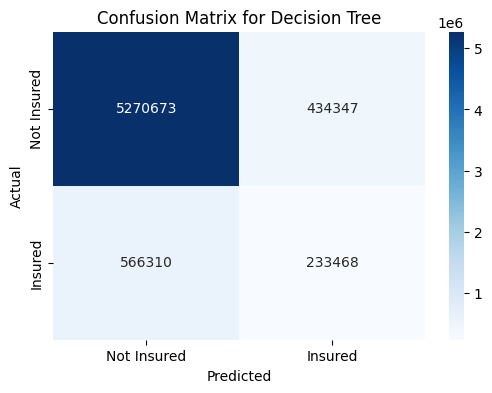

              precision    recall  f1-score   support

           0       0.90      0.92      0.91   5705020
           1       0.35      0.29      0.32    799778

    accuracy                           0.85   6504798
   macro avg       0.63      0.61      0.62   6504798
weighted avg       0.83      0.85      0.84   6504798



In [23]:
evaluate_model(tree_model, "Decision Tree")

## Рандомный лес

In [28]:
rf_model = RandomForestClassifier(random_state=37, n_estimators=40, max_depth=150, min_samples_split=2)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
f1_score(y_test, rf_pred)

np.float64(0.2678848572968911)

In [ ]:
rf_param_grid = {'n_estimators': [10, 50, 100, 200], 'max_depth': [30, 50, 100], 'min_samples_split': [20, 60, 100]}
rf_model_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, scoring='f1')
rf_model_grid.fit(X_train, y_train)
print("Random Forest Best Params:", rf_model_grid.best_params_)
print(f'Best Cross-Validation Score: {rf_model_grid.best_score_}')

KeyboardInterrupt: 

In [ ]:
# # 1. Decision Tree
# tree_param_grid = {'max_depth': [3, 5, 10], 'min_samples_split': [5, 10, 15]}
# tree_model = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_param_grid, cv=5)
# tree_model.fit(X_train, y_train)
# print("Decision Tree Best Params:", tree_model.best_params_)

# # 2. Random Forest


# # 3. K-Nearest Neighbors (KNN)
# knn_param_grid = {'n_neighbors': [3, 5, 7, 9]}
# knn_model = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5)
# knn_model.fit(X_train, y_train)
# print("KNN Best Params:", knn_model.best_params_)

# # 4. Support Vector Machine (SVM)
# svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
# svm_model = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=5)
# svm_model.fit(X_train, y_train)
# print("SVM Best Params:", svm_model.best_params_)

### Получается не очень, попробуем избавиться от признаков Policy_Sales_Channel и Region_Code

In [20]:
df = df.drop(['Policy_Sales_Channel', 'Region_Code'], axis=1)
df_test = df_test.drop(['Policy_Sales_Channel', 'Region_Code'], axis=1)

df = pd.get_dummies(df, drop_first=True)
df_test = pd.get_dummies(df_test, drop_first=True)
df.head()

,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response,Gender_Male
0,-1.159421,True,False,0.698792,True,2.101969,0.288605,0,True
1,0.307563,True,False,2.459899,True,1.726275,1.551506,1,True
2,-0.892696,True,True,-1.062316,False,0.459721,1.126371,0,False
3,-0.225886,True,False,0.698792,True,-1.689623,-1.099336,0,False
4,-0.159205,True,True,0.698792,False,0.089975,1.626530,0,False


In [21]:

X_train = df.drop('Response', axis=1)
y_train = df['Response']

X_test = df_test.drop('Response', axis=1)
y_test = df_test['Response']



## Дерево без категориальных признаков

In [20]:
tree_model = DecisionTreeClassifier(random_state=37, max_depth=90, min_samples_split=10)
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)
f1_score(y_test, tree_pred)

np.float64(0.2955914240992576)

## Рандомный лес без категориальных признаков

In [22]:
rf_model = RandomForestClassifier(random_state=37, n_estimators=40, max_depth=150, min_samples_split=2)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
f1_score(y_test, rf_pred)

np.float64(0.28074389461390387)

### Попробуем без достаточно сильно коррелированного признака Vehicle_age

In [40]:
tree_model = DecisionTreeClassifier(random_state=42, max_depth=80, min_samples_split=2)
tree_model.fit(X_train.drop('Vehicle_Age', axis=1), y_train)
tree_pred = tree_model.predict(X_test.drop('Vehicle_Age', axis=1))
f1_score(y_test, tree_pred)

np.float64(0.3056735945302452)

In [38]:
rf_model = RandomForestClassifier(random_state=37, n_estimators=60, max_depth=75, min_samples_split=2)
rf_model.fit(X_train.drop('Vehicle_Age', axis=1), y_train)
rf_pred = rf_model.predict(X_test.drop('Vehicle_Age', axis=1))
f1_score(y_test, rf_pred)


np.float64(0.27859548690363095)

In [41]:
roc_auc_score(y_test, tree_pred)

np.float64(0.6018116082235415)

In [33]:
evaluate_model(rf_model, "Decision Tree")


--- Decision Tree ---


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Vehicle_Age


## SVM

In [86]:
svm_model = SVC(random_state=37, C=1, kernel='rbf')
svm_model.fit(X_train, y_train)
svm_pred = rf_model.predict(X_test)
f1_score(y_test, svm_pred)

: 

: 

## Logistic Regression

In [ ]:
log_reg_model = LogisticRegression(random_state=37, max_iter=1000, C=0.1, penalty='l1', solver='liblinear')
log_reg_model.fit(X_train, y_train)
pred = log_reg_model.predict(X_test)
f1_score(y_test, pred)